In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [2]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [3]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [4]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [5]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [8]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [10]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [11]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [12]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [13]:
# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 64
num_folds: int = 4
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-4
epochs: int = 250
starting_lr: float = 1e-2
scale: float = 7.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 256

# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    # return BasicMLP(input_features, output_features).to(device)
    return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds)

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.75,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                eta_min=1e-5
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()


# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)

# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/4 ==================================


Epoch:   2%|▏         | 5/250 [00:15<12:18,  3.01s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.6426 | val normalized MSE   0.4974, | val MAE   2.8869 | val MSE  24.3729


Epoch:   4%|▍         | 10/250 [00:29<11:06,  2.78s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.3537 | val normalized MSE   0.3290, | val MAE   2.3005 | val MSE  16.1198


Epoch:   6%|▌         | 15/250 [00:42<10:38,  2.72s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.3161 | val normalized MSE   0.3056, | val MAE   2.2169 | val MSE  14.9761


Epoch:   8%|▊         | 20/250 [00:56<10:42,  2.79s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.2777 | val normalized MSE   0.2622, | val MAE   1.9375 | val MSE  12.8458


Epoch:  10%|█         | 25/250 [01:10<10:33,  2.82s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.2495 | val normalized MSE   0.2360, | val MAE   1.7569 | val MSE  11.5645


Epoch:  12%|█▏        | 30/250 [01:24<10:15,  2.80s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.2207 | val normalized MSE   0.2154, | val MAE   1.5998 | val MSE  10.5529


Epoch:  14%|█▍        | 35/250 [01:38<09:59,  2.79s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.2159 | val normalized MSE   0.2119, | val MAE   1.6571 | val MSE  10.3848


Epoch:  16%|█▌        | 40/250 [01:52<09:34,  2.74s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.2020 | val normalized MSE   0.2145, | val MAE   1.6502 | val MSE  10.5095


Epoch:  18%|█▊        | 45/250 [02:06<09:43,  2.85s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.1973 | val normalized MSE   0.2064, | val MAE   1.6142 | val MSE  10.1119


Epoch:  20%|██        | 50/250 [02:20<09:27,  2.84s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.2018 | val normalized MSE   0.1993, | val MAE   1.4698 | val MSE   9.7653


Epoch:  22%|██▏       | 55/250 [02:34<09:02,  2.78s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.1800 | val normalized MSE   0.1901, | val MAE   1.4776 | val MSE   9.3145


Epoch:  24%|██▍       | 60/250 [02:47<08:30,  2.68s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.1799 | val normalized MSE   0.2004, | val MAE   1.5757 | val MSE   9.8214


Epoch:  26%|██▌       | 65/250 [03:01<08:33,  2.78s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.2226 | val normalized MSE   0.2355, | val MAE   1.7802 | val MSE  11.5394


Epoch:  28%|██▊       | 70/250 [03:15<08:19,  2.77s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.1833 | val normalized MSE   0.1879, | val MAE   1.4517 | val MSE   9.2087


Epoch:  30%|███       | 75/250 [03:29<08:18,  2.85s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.1803 | val normalized MSE   0.1974, | val MAE   1.5290 | val MSE   9.6704


Epoch:  32%|███▏      | 80/250 [03:44<08:12,  2.90s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.1706 | val normalized MSE   0.1857, | val MAE   1.4272 | val MSE   9.0972


Epoch:  34%|███▍      | 85/250 [03:58<07:46,  2.83s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.1659 | val normalized MSE   0.1865, | val MAE   1.4067 | val MSE   9.1397


Epoch:  36%|███▌      | 90/250 [04:12<07:24,  2.78s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1674 | val normalized MSE   0.1885, | val MAE   1.4357 | val MSE   9.2377


Epoch:  38%|███▊      | 95/250 [04:27<07:29,  2.90s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1636 | val normalized MSE   0.1909, | val MAE   1.4472 | val MSE   9.3519


Epoch:  40%|████      | 100/250 [04:40<06:55,  2.77s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1615 | val normalized MSE   0.1860, | val MAE   1.4252 | val MSE   9.1147


Epoch:  42%|████▏     | 105/250 [04:54<06:33,  2.71s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1576 | val normalized MSE   0.1823, | val MAE   1.3950 | val MSE   8.9329


Epoch:  44%|████▍     | 110/250 [05:08<06:28,  2.77s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.1556 | val normalized MSE   0.1827, | val MAE   1.4115 | val MSE   8.9528


Epoch:  46%|████▌     | 115/250 [05:22<06:18,  2.81s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1552 | val normalized MSE   0.1863, | val MAE   1.4215 | val MSE   9.1267


Epoch:  48%|████▊     | 120/250 [05:36<05:57,  2.75s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1542 | val normalized MSE   0.1860, | val MAE   1.4065 | val MSE   9.1137


Epoch:  50%|█████     | 125/250 [05:49<05:39,  2.71s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.1551 | val normalized MSE   0.1840, | val MAE   1.3931 | val MSE   9.0174


Epoch:  51%|█████     | 128/250 [06:00<05:43,  2.82s/epoch]

==== EARLY STOP at epoch 129

FOLD 2/4 ==================================



Epoch:   2%|▏         | 5/250 [00:23<19:00,  4.66s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.3478 | val normalized MSE   0.3805, | val MAE   2.5019 | val MSE  18.6434


Epoch:   4%|▍         | 10/250 [00:46<18:13,  4.56s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.2701 | val normalized MSE   0.2957, | val MAE   2.0548 | val MSE  14.4878


Epoch:   6%|▌         | 15/250 [01:09<17:58,  4.59s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.2415 | val normalized MSE   0.2506, | val MAE   1.7817 | val MSE  12.2783


Epoch:   8%|▊         | 20/250 [01:32<17:50,  4.65s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.2182 | val normalized MSE   0.2341, | val MAE   1.7467 | val MSE  11.4697


Epoch:  10%|█         | 25/250 [01:55<17:13,  4.59s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.2095 | val normalized MSE   0.2250, | val MAE   1.6666 | val MSE  11.0267


Epoch:  12%|█▏        | 30/250 [02:18<16:56,  4.62s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.1929 | val normalized MSE   0.2138, | val MAE   1.6265 | val MSE  10.4747


Epoch:  14%|█▍        | 35/250 [02:42<16:40,  4.66s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.1918 | val normalized MSE   0.2646, | val MAE   1.8189 | val MSE  12.9667


Epoch:  16%|█▌        | 40/250 [03:04<15:57,  4.56s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.1985 | val normalized MSE   0.2076, | val MAE   1.5698 | val MSE  10.1744


Epoch:  18%|█▊        | 45/250 [03:28<15:52,  4.65s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.1828 | val normalized MSE   0.1967, | val MAE   1.4864 | val MSE   9.6380


Epoch:  20%|██        | 50/250 [03:51<15:23,  4.62s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.1792 | val normalized MSE   0.1992, | val MAE   1.4942 | val MSE   9.7585


Epoch:  22%|██▏       | 55/250 [04:14<14:56,  4.60s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.1745 | val normalized MSE   0.2006, | val MAE   1.4968 | val MSE   9.8313


Epoch:  24%|██▍       | 60/250 [04:37<14:46,  4.67s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.1696 | val normalized MSE   0.1949, | val MAE   1.4709 | val MSE   9.5504


Epoch:  26%|██▌       | 65/250 [05:00<14:03,  4.56s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.1659 | val normalized MSE   0.1982, | val MAE   1.5020 | val MSE   9.7116


Epoch:  28%|██▊       | 70/250 [05:23<13:56,  4.65s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.1626 | val normalized MSE   0.1940, | val MAE   1.4581 | val MSE   9.5038


Epoch:  30%|███       | 75/250 [05:46<13:40,  4.69s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.1636 | val normalized MSE   0.1888, | val MAE   1.4158 | val MSE   9.2522


Epoch:  32%|███▏      | 80/250 [06:09<13:02,  4.60s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.1579 | val normalized MSE   0.1907, | val MAE   1.4578 | val MSE   9.3425


Epoch:  34%|███▍      | 85/250 [06:33<12:53,  4.69s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.1555 | val normalized MSE   0.1942, | val MAE   1.4691 | val MSE   9.5156


Epoch:  36%|███▌      | 90/250 [06:56<12:20,  4.63s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1525 | val normalized MSE   0.1891, | val MAE   1.4303 | val MSE   9.2677


Epoch:  38%|███▊      | 95/250 [07:19<11:50,  4.58s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1530 | val normalized MSE   0.1897, | val MAE   1.4365 | val MSE   9.2941


Epoch:  40%|████      | 100/250 [07:43<11:57,  4.78s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1528 | val normalized MSE   0.1851, | val MAE   1.4392 | val MSE   9.0711


Epoch:  42%|████▏     | 105/250 [08:06<11:14,  4.65s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1454 | val normalized MSE   0.1850, | val MAE   1.4093 | val MSE   9.0630


Epoch:  44%|████▍     | 110/250 [08:29<10:51,  4.65s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.1451 | val normalized MSE   0.1856, | val MAE   1.4061 | val MSE   9.0968


Epoch:  46%|████▌     | 115/250 [08:53<10:26,  4.64s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1418 | val normalized MSE   0.1862, | val MAE   1.4055 | val MSE   9.1254


Epoch:  48%|████▊     | 120/250 [09:15<09:50,  4.54s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1397 | val normalized MSE   0.1891, | val MAE   1.4329 | val MSE   9.2673


Epoch:  50%|█████     | 125/250 [09:39<09:49,  4.72s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.1388 | val normalized MSE   0.1879, | val MAE   1.4138 | val MSE   9.2086


Epoch:  52%|█████▏    | 130/250 [10:02<09:12,  4.61s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   0.1345 | val normalized MSE   0.1876, | val MAE   1.4078 | val MSE   9.1943


Epoch:  52%|█████▏    | 131/250 [10:11<09:15,  4.67s/epoch]

==== EARLY STOP at epoch 132

FOLD 3/4 ==================================



Epoch:   2%|▏         | 5/250 [00:32<26:52,  6.58s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.2964 | val normalized MSE   0.2858, | val MAE   1.8802 | val MSE  14.0019


Epoch:   4%|▍         | 10/250 [01:04<25:42,  6.43s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.2399 | val normalized MSE   0.2359, | val MAE   1.8064 | val MSE  11.5571


Epoch:   6%|▌         | 15/250 [01:37<25:29,  6.51s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.2125 | val normalized MSE   0.2097, | val MAE   1.5695 | val MSE  10.2771


Epoch:   8%|▊         | 20/250 [02:10<24:57,  6.51s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.2012 | val normalized MSE   0.2111, | val MAE   1.6744 | val MSE  10.3446


Epoch:  10%|█         | 25/250 [02:43<24:22,  6.50s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.1981 | val normalized MSE   0.2106, | val MAE   1.6192 | val MSE  10.3176


Epoch:  12%|█▏        | 30/250 [03:15<23:45,  6.48s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.2128 | val normalized MSE   0.2075, | val MAE   1.5960 | val MSE  10.1684


Epoch:  14%|█▍        | 35/250 [03:48<23:29,  6.55s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.1955 | val normalized MSE   0.2149, | val MAE   1.7081 | val MSE  10.5317


Epoch:  16%|█▌        | 40/250 [04:20<22:50,  6.53s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.1888 | val normalized MSE   0.1933, | val MAE   1.5258 | val MSE   9.4712


Epoch:  18%|█▊        | 45/250 [04:53<22:16,  6.52s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.1891 | val normalized MSE   0.1941, | val MAE   1.4993 | val MSE   9.5087


Epoch:  20%|██        | 50/250 [05:25<21:44,  6.52s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.1872 | val normalized MSE   0.1937, | val MAE   1.5253 | val MSE   9.4904


Epoch:  22%|██▏       | 55/250 [05:58<21:15,  6.54s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.1810 | val normalized MSE   0.1837, | val MAE   1.4106 | val MSE   9.0013


Epoch:  24%|██▍       | 60/250 [06:31<20:38,  6.52s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.1789 | val normalized MSE   0.1830, | val MAE   1.4461 | val MSE   8.9666


Epoch:  26%|██▌       | 65/250 [07:03<19:44,  6.40s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.1752 | val normalized MSE   0.1829, | val MAE   1.3887 | val MSE   8.9613


Epoch:  28%|██▊       | 70/250 [07:35<19:33,  6.52s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.1758 | val normalized MSE   0.1831, | val MAE   1.4424 | val MSE   8.9740


Epoch:  30%|███       | 75/250 [08:08<18:56,  6.49s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.1729 | val normalized MSE   0.1861, | val MAE   1.5009 | val MSE   9.1212


Epoch:  32%|███▏      | 80/250 [08:41<18:26,  6.51s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.1706 | val normalized MSE   0.1819, | val MAE   1.3656 | val MSE   8.9109


Epoch:  34%|███▍      | 85/250 [09:13<17:45,  6.46s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.1673 | val normalized MSE   0.1803, | val MAE   1.3805 | val MSE   8.8324


Epoch:  36%|███▌      | 90/250 [09:45<17:18,  6.49s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1673 | val normalized MSE   0.1820, | val MAE   1.3861 | val MSE   8.9200


Epoch:  38%|███▊      | 95/250 [10:18<16:46,  6.49s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1660 | val normalized MSE   0.1795, | val MAE   1.3716 | val MSE   8.7967


Epoch:  40%|████      | 100/250 [10:51<16:19,  6.53s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1627 | val normalized MSE   0.1786, | val MAE   1.4061 | val MSE   8.7523


Epoch:  42%|████▏     | 105/250 [11:23<15:48,  6.54s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1609 | val normalized MSE   0.1785, | val MAE   1.4035 | val MSE   8.7445


Epoch:  44%|████▍     | 110/250 [11:56<15:19,  6.57s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.1597 | val normalized MSE   0.1759, | val MAE   1.3549 | val MSE   8.6205


Epoch:  46%|████▌     | 115/250 [12:29<14:47,  6.57s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1587 | val normalized MSE   0.1778, | val MAE   1.3824 | val MSE   8.7136


Epoch:  48%|████▊     | 120/250 [13:01<14:04,  6.49s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1571 | val normalized MSE   0.1768, | val MAE   1.3696 | val MSE   8.6638


Epoch:  50%|█████     | 125/250 [13:34<13:36,  6.53s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.1547 | val normalized MSE   0.1766, | val MAE   1.3720 | val MSE   8.6549


Epoch:  52%|█████▏    | 130/250 [14:06<12:57,  6.48s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   0.1533 | val normalized MSE   0.1763, | val MAE   1.3869 | val MSE   8.6395


Epoch:  54%|█████▍    | 135/250 [14:39<12:34,  6.56s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   0.1523 | val normalized MSE   0.1770, | val MAE   1.3472 | val MSE   8.6718


Epoch:  56%|█████▌    | 140/250 [15:11<11:48,  6.44s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   0.1519 | val normalized MSE   0.1793, | val MAE   1.3607 | val MSE   8.7881


Epoch:  58%|█████▊    | 145/250 [15:44<11:35,  6.62s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   0.1505 | val normalized MSE   0.1760, | val MAE   1.3610 | val MSE   8.6238


Epoch:  60%|██████    | 150/250 [16:17<10:55,  6.56s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   0.1482 | val normalized MSE   0.1768, | val MAE   1.3562 | val MSE   8.6651


Epoch:  62%|██████▏   | 155/250 [16:50<10:22,  6.55s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   0.1500 | val normalized MSE   0.1766, | val MAE   1.3519 | val MSE   8.6557


Epoch:  64%|██████▍   | 160/250 [17:22<09:46,  6.51s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   0.1494 | val normalized MSE   0.1776, | val MAE   1.3570 | val MSE   8.7048


Epoch:  66%|██████▌   | 165/250 [17:55<09:17,  6.56s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   0.1476 | val normalized MSE   0.1767, | val MAE   1.3424 | val MSE   8.6594


Epoch:  68%|██████▊   | 170/250 [18:27<08:40,  6.51s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   0.1475 | val normalized MSE   0.1776, | val MAE   1.3547 | val MSE   8.7046


Epoch:  69%|██████▉   | 173/250 [18:53<08:24,  6.55s/epoch]

==== EARLY STOP at epoch 174

FOLD 4/4 ==================================



Epoch:   2%|▏         | 5/250 [00:42<34:20,  8.41s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.2980 | val normalized MSE   0.2778, | val MAE   1.9502 | val MSE  13.6107


Epoch:   4%|▍         | 10/250 [01:24<33:41,  8.42s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.2456 | val normalized MSE   0.2523, | val MAE   1.9637 | val MSE  12.3643


Epoch:   6%|▌         | 15/250 [02:06<33:10,  8.47s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.2156 | val normalized MSE   0.2211, | val MAE   1.6256 | val MSE  10.8342


Epoch:   8%|▊         | 20/250 [02:49<32:37,  8.51s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.1988 | val normalized MSE   0.2116, | val MAE   1.6424 | val MSE  10.3704


Epoch:  10%|█         | 25/250 [03:32<31:58,  8.53s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.1930 | val normalized MSE   0.2098, | val MAE   1.5755 | val MSE  10.2817


Epoch:  12%|█▏        | 30/250 [04:14<30:58,  8.45s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.1836 | val normalized MSE   0.1843, | val MAE   1.4544 | val MSE   9.0331


Epoch:  14%|█▍        | 35/250 [04:56<30:18,  8.46s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.1842 | val normalized MSE   0.1819, | val MAE   1.4390 | val MSE   8.9117


Epoch:  16%|█▌        | 40/250 [05:39<29:47,  8.51s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.1803 | val normalized MSE   0.1831, | val MAE   1.4775 | val MSE   8.9715


Epoch:  18%|█▊        | 45/250 [06:20<28:36,  8.37s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.1791 | val normalized MSE   0.1890, | val MAE   1.5809 | val MSE   9.2617


Epoch:  20%|██        | 50/250 [07:03<28:04,  8.42s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.1738 | val normalized MSE   0.1830, | val MAE   1.4845 | val MSE   8.9667


Epoch:  22%|██▏       | 55/250 [07:45<27:38,  8.50s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.1701 | val normalized MSE   0.1779, | val MAE   1.4055 | val MSE   8.7170


Epoch:  24%|██▍       | 60/250 [08:27<26:34,  8.39s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.1686 | val normalized MSE   0.1861, | val MAE   1.5595 | val MSE   9.1177


Epoch:  26%|██▌       | 65/250 [09:10<26:08,  8.48s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.1666 | val normalized MSE   0.1696, | val MAE   1.3434 | val MSE   8.3125


Epoch:  28%|██▊       | 70/250 [09:52<25:32,  8.52s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.1644 | val normalized MSE   0.1737, | val MAE   1.3710 | val MSE   8.5091


Epoch:  30%|███       | 75/250 [10:34<24:38,  8.45s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.1624 | val normalized MSE   0.1733, | val MAE   1.3788 | val MSE   8.4939


Epoch:  32%|███▏      | 80/250 [11:17<24:01,  8.48s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.1577 | val normalized MSE   0.1724, | val MAE   1.3674 | val MSE   8.4456


Epoch:  34%|███▍      | 85/250 [11:59<23:29,  8.54s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.1586 | val normalized MSE   0.1719, | val MAE   1.3637 | val MSE   8.4225


Epoch:  36%|███▌      | 90/250 [12:43<23:09,  8.68s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1566 | val normalized MSE   0.1722, | val MAE   1.3790 | val MSE   8.4369


Epoch:  38%|███▊      | 95/250 [13:25<22:03,  8.54s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1562 | val normalized MSE   0.1689, | val MAE   1.3435 | val MSE   8.2777


Epoch:  40%|████      | 100/250 [14:08<21:13,  8.49s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1517 | val normalized MSE   0.1682, | val MAE   1.3346 | val MSE   8.2402


Epoch:  42%|████▏     | 105/250 [14:50<20:32,  8.50s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1495 | val normalized MSE   0.1690, | val MAE   1.3250 | val MSE   8.2808


Epoch:  44%|████▍     | 110/250 [15:33<19:46,  8.48s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.1473 | val normalized MSE   0.1710, | val MAE   1.3257 | val MSE   8.3781


Epoch:  46%|████▌     | 115/250 [16:15<18:58,  8.44s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1486 | val normalized MSE   0.1708, | val MAE   1.3423 | val MSE   8.3688


Epoch:  48%|████▊     | 120/250 [16:57<18:24,  8.50s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1460 | val normalized MSE   0.1693, | val MAE   1.3324 | val MSE   8.2967


Epoch:  50%|█████     | 125/250 [17:40<17:40,  8.49s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.1444 | val normalized MSE   0.1692, | val MAE   1.3256 | val MSE   8.2909


Epoch:  52%|█████▏    | 130/250 [18:22<16:49,  8.41s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   0.1403 | val normalized MSE   0.1688, | val MAE   1.3286 | val MSE   8.2704


Epoch:  54%|█████▍    | 135/250 [19:04<16:17,  8.50s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   0.1422 | val normalized MSE   0.1700, | val MAE   1.3257 | val MSE   8.3278


Epoch:  56%|█████▌    | 140/250 [19:47<15:35,  8.50s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   0.1407 | val normalized MSE   0.1696, | val MAE   1.3096 | val MSE   8.3123


Epoch:  57%|█████▋    | 143/250 [20:20<15:13,  8.54s/epoch]

==== EARLY STOP at epoch 144


Submission saved locally as: './submission\submission-2025-05-12_10-18AM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [14]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [15]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(val_dataset, Dataset):
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        else:
            batch_x, batch_y = batch
        
        pred = model(batch)
        gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
        gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

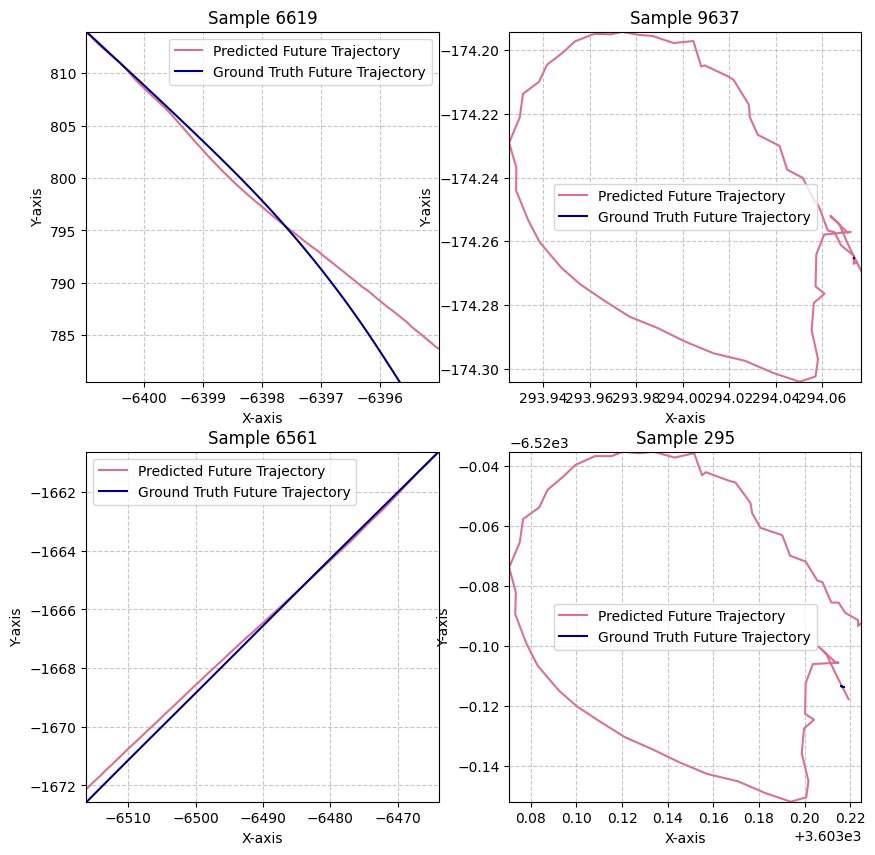

In [17]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)